In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
# import dataset and split into the Training and Test set
df = pd.read_csv('mnist_binary.csv')
print('The shape of raw data: ', df.shape)
df = df[:1000]
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('The shape of Training data: ',X_train.shape, y_train.shape)
print('The shape of Test data: ',X_test.shape, y_test.shape)
print('X_train', X_train[:2])

The shape of raw data:  (10000, 785)
The shape of Training data:  (800, 784) (800,)
The shape of Test data:  (200, 784) (200,)
X_train [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
class AdaBoost:
    def __init__(self, T=50):
        self.T = T
        self.weak_classifiers = []

    def train(self, X, Y):
        # m is the number of samples, n is number of features
        m, n = X.shape
        # initialize weights
        w = np.ones(m) / m

        for t in range(self.T):
            # initialize a dictionary as weak classifier selector
            best_weak_classifier = {'feature': 0, 'threshold': 0, 'min_error': np.inf,
                                    'is_greater_than_threshold': 1, 'alpha': 0}

            # search for the best weak classifier in all features
            for j in range(n):
                x_samples = X[:, j]

                # sort the samples from lowest value to highest
                thresholds = np.sort(x_samples)

                # search for the best threshold that can minimize the total error
                for threshold in thresholds:

                    # we predict the sample value that is greater than threshold as positive prediction
                    is_greater_than_threshold = 1
                    predictions = np.ones(m)
                    predictions[x_samples < threshold] = -1

                    # sum of weights of misclassified samples to get the total error
                    misclassified_weights = w[Y != predictions]
                    total_error = sum(misclassified_weights)

                    # Since we are minimizing error, if the error rate is higher than 0.5, we flip the sign
                    # (from "greater than threshold" to the "less than threshold") to get the minimum error rate
                    if total_error > 0.5:
                        total_error = 1 - total_error

                        # reset is_greater_than_threshold = -1 means now we mark the sample value that
                        # less than threshold as positive prediction in this weak classifier
                        is_greater_than_threshold = -1

                    if total_error < best_weak_classifier['min_error']:

                        # only keep the best weak classifier's details
                        best_weak_classifier['feature'] = j
                        best_weak_classifier['threshold'] = threshold
                        best_weak_classifier['min_error'] = total_error
                        best_weak_classifier['is_greater_than_threshold'] = is_greater_than_threshold

            # calculate the alpha, add 1e-10 on denominator to avoid dividing by zero
            best_weak_classifier['alpha'] = 1 / 2 * np.log(
                (1.0 - best_weak_classifier['min_error']) / max(best_weak_classifier['min_error'], 1e-10))

            # store the best decision stump into weak classifier list
            self.weak_classifiers.append(best_weak_classifier)

            # get predictions on a single weak classifier
            weak_classifier_predictions = self.weak_classify(X[:, best_weak_classifier['feature']],
                                                             best_weak_classifier['threshold'],
                                                             best_weak_classifier['is_greater_than_threshold'])

            # update the weights
            w = w * np.exp((-1) * float(best_weak_classifier['alpha']) * Y * weak_classifier_predictions)
            # get the normalization factor Z
            z = np.sum(w)
            w = w / z
            print("alpha", t + 1, ': ', best_weak_classifier['alpha'])

    @staticmethod
    def weak_classify(X_column, threshold, is_greater_than_threshold):
        # predict based on single weak classifier
        predictions = np.ones(X_column.shape[0])
        if is_greater_than_threshold == 1:
            predictions[X_column < threshold] = -1
        else:
            predictions[X_column > threshold] = -1

        return predictions

    def predict(self, X):
        prediction = [wcl['alpha'] * self.weak_classify(
            X[:, wcl['feature']], wcl['threshold'], wcl['is_greater_than_threshold']) for wcl in self.weak_classifiers]
        Y = np.sum(prediction, axis=0)
        Y = np.sign(Y)
        return Y

In [8]:
print('==========Train==========')
classifier = AdaBoost(T=10)
classifier.train(X_train, y_train)
y_pred = classifier.predict(X_test)

==========Train==========
alpha 1 :  11.51292546497022
alpha 2 :  11.512925464970229
alpha 3 :  11.512925464970234
alpha 4 :  11.512925464970225
alpha 5 :  11.512925464970229
alpha 6 :  11.512925464970229
alpha 7 :  11.512925464970229
alpha 8 :  11.512925464970229
alpha 9 :  11.512925464970229
alpha 10 :  11.512925464970229


In [9]:
# Test
y_pred = classifier.predict(X_test)

In [10]:
# Other Evaluation Metrics
mse = np.sum(np.power(y_pred - y_test,2))/(len(X_test))
rmse = np.sqrt(mse)
R2_test = 1 - np.sum(np.power(y_pred - y_test,2))/np.sum(np.power(np.mean(y_test) - y_test,2))
print('MSE = ', mse)
print('RMSE = ', rmse)
print('R2_test = ', R2_test)
print('accuracy = ', accuracy_score(y_test, y_pred))
print('precision = ', precision_score(y_test, y_pred))
print('recall = ', recall_score(y_test, y_pred))
print('F1 = ', f1_score(y_test, y_pred))

MSE =  0.14
RMSE =  0.37416573867739417
R2_test =  -0.16279069767441867
accuracy =  0.86
precision =  0.86
recall =  1.0
F1 =  0.924731182795699


fpr:[0. 1.]
tpr:[0. 1.]
thresholds:[2. 1.]
AUC面积值： 0.5
AUC面积得分： 0.5


/home/ubuntu/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20026 (\N{CJK UNIFIED IDEOGRAPH-4E3A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from c

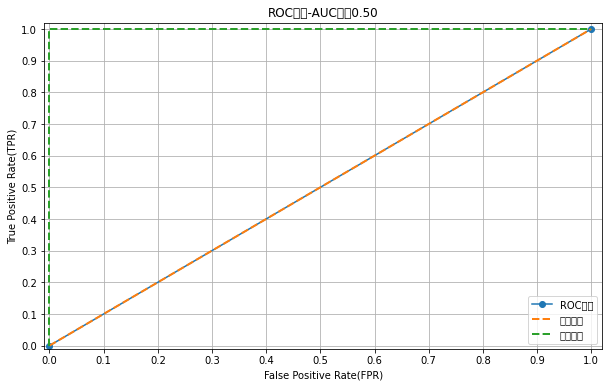

In [11]:
# ROC AUC
#返回ROC曲线相关值。返回FPR,TPR与阈值，当分值达到阈值时，将样本判定为正类，否则判定为负类。
#y_true：二分类的标签值（真实值）
#y_score：每个标签（数据）的分值或概率值。当该值达到阈值时，判定为正例，否则判定为负例。
#在实际模型评估时，该值往往通过决策函数（decision_function）或概率函数（predict_proba）获得
#pos_label：指定正例的标签值
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print(f'fpr:{fpr}')
print(f'tpr:{tpr}')
print(f'thresholds:{thresholds}')
#auc与roc_auc_score函数都可以返回auc面积值，但是注意，两个函数的参数是不同的
print('AUC面积值：', auc(fpr, tpr))
print('AUC面积得分：', roc_auc_score(y_true=y_test, y_score=y_pred))

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, ls='-', marker='o', label='ROC曲线')
plt.plot([0,1], [0,1], lw=2, ls='--', label='随机猜想')
plt.plot([0,0,1], [0,1,1], lw=2, ls='--', label='完美预测')
plt.xlim(-0.01, 1.02)
plt.ylim(-0.01, 1.02)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title(f'ROC曲线-AUC值为{auc(fpr, tpr):.2f}')
plt.grid()
plt.legend()